# Round trip and spot-checking the tuned model

January 2022

gully


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
active_lower, active_upper = 8079, 12785
line_threshold_lower, line_threshold_upper = 8049, 12815

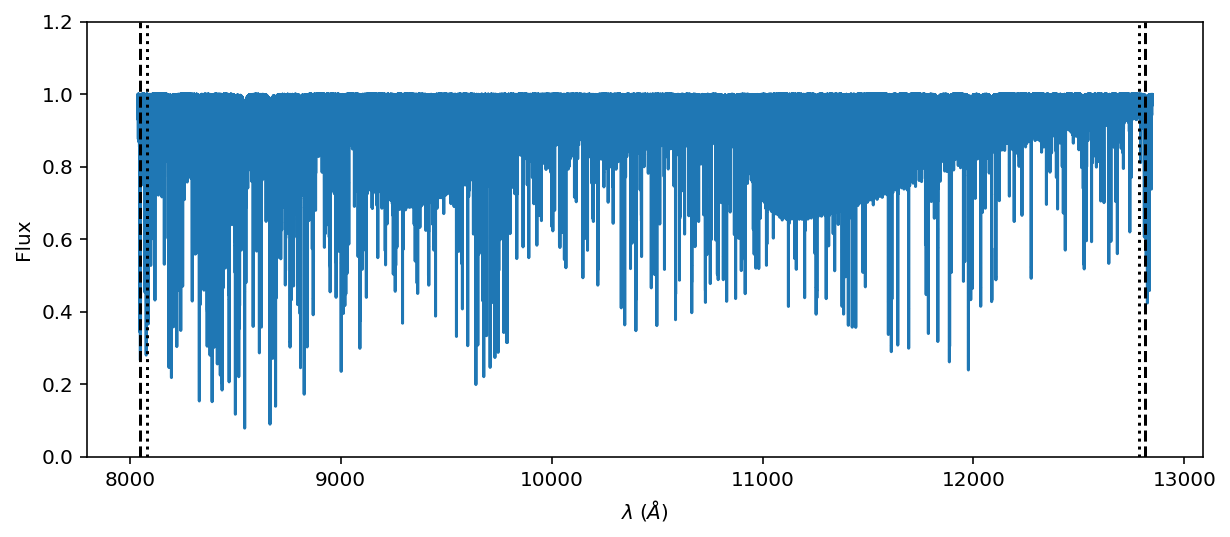

In [6]:
ax = spectrum.plot(ylo=0);
ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k');

In [7]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [8]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 8714 spectral lines


In [9]:
state_dict_init = emulator.state_dict()

In [10]:
state_dict_init['lam_centers'].shape

torch.Size([8714])

In [11]:
state_dict_post = torch.load('../examples/sparse_T4700g4p5_prom0p01_HPF.pt')

In [12]:
emulator.load_state_dict(state_dict_post)

<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    spec_out = emulator.forward().numpy()

CPU times: user 1.36 s, sys: 714 ms, total: 2.08 s
Wall time: 457 ms


In [15]:
wl = emulator.wl_native[emulator.active_mask].numpy()
flux = emulator.flux_native[emulator.active_mask].numpy()

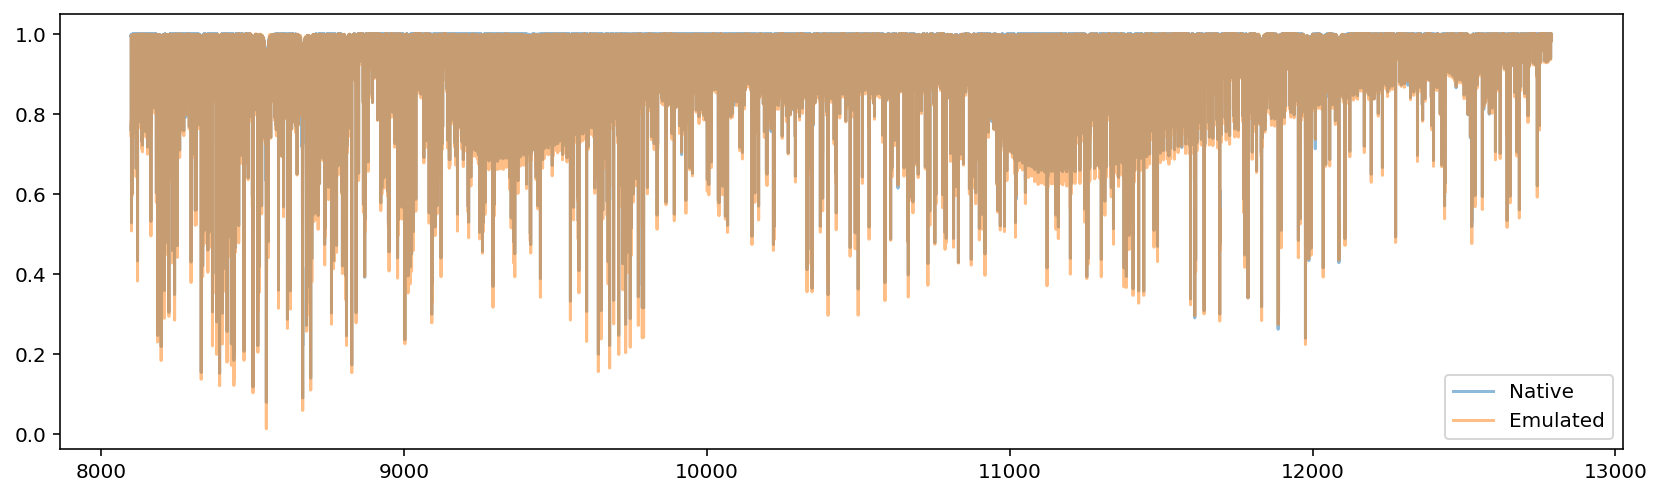

In [16]:
plt.figure(figsize=(14, 4))
plt.plot(wl, flux, alpha=0.5, label = 'Native')
plt.plot(wl, spec_out, alpha=0.5, label = 'Emulated')
plt.legend();

In [17]:
residual = flux - spec_out

(-0.1, 0.1)

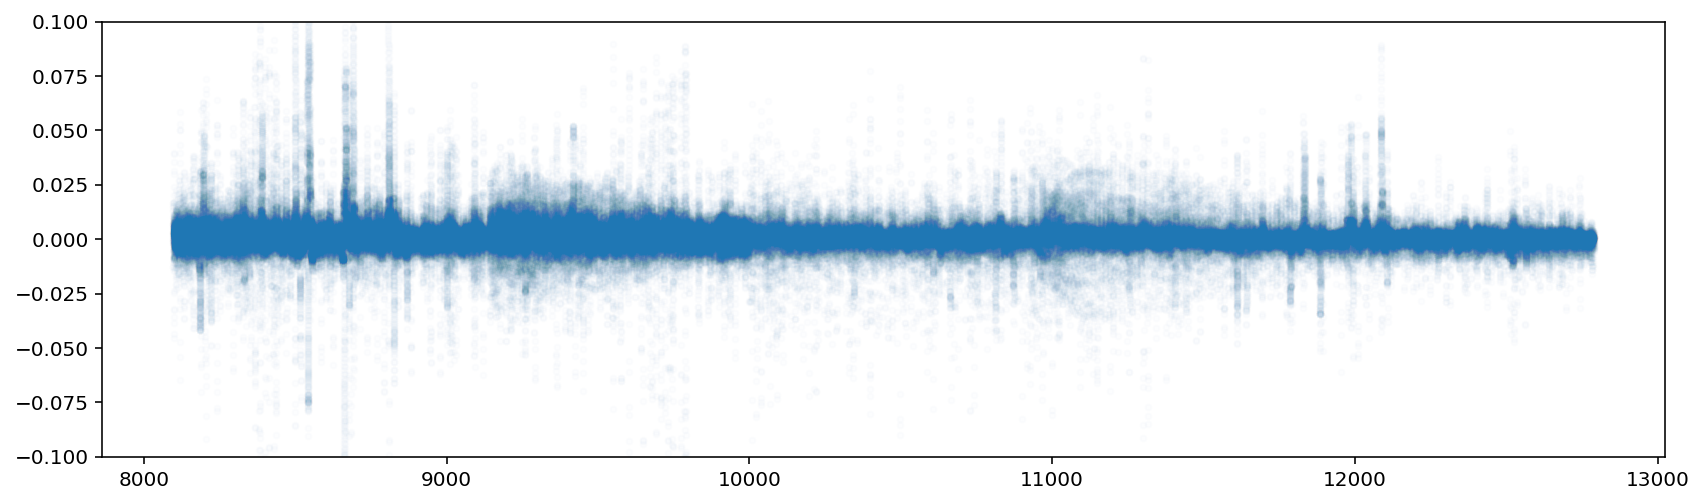

In [18]:
plt.figure(figsize=(14, 4))
plt.plot(wl, residual, '.', alpha=0.01)
plt.ylim(-0.1, 0.1)

Let's pick specific lines and drill down on them:

In [19]:
def sparse_pseudo_Voigt_model(emulator):
    """A sparse pseudo-Voigt model

    Note:
        Almost the same as the base class implementation, may want to refactor

    Returns:
        (torch.tensor): the 1D generative spectral model destined for backpropagation parameter tuning
    """
    fwhm_G = 2.3548 * torch.exp(emulator.sigma_widths).unsqueeze(1)
    fwhm_L = 2.0 * torch.exp(emulator.gamma_widths).unsqueeze(1)
    fwhm = emulator._compute_fwhm(fwhm_L, fwhm_G)
    eta = emulator._compute_eta(fwhm_L, fwhm)

    flux_2D = torch.exp(emulator.amplitudes).unsqueeze(1) * (
        eta
        * emulator.lorentzian_line(
            emulator.lam_centers.unsqueeze(1),
            torch.exp(emulator.gamma_widths).unsqueeze(1),
            emulator.wl_2D,
        )
        + (1 - eta)
        * emulator.gaussian_line(
            emulator.lam_centers.unsqueeze(1),
            torch.exp(emulator.sigma_widths).unsqueeze(1),
            emulator.wl_2D,
        )
    )

    return flux_2D

In [20]:
with torch.no_grad():
    flux_2D = sparse_pseudo_Voigt_model(emulator)

## Pick a single line to drill down on

In [21]:
ii = 1234

In [22]:
sorted_inds_amplitude = np.argsort(state_dict_post['gamma_widths'])

In [23]:
jj = -1

In [27]:
jj-=100
ii = sorted_inds_amplitude[jj]

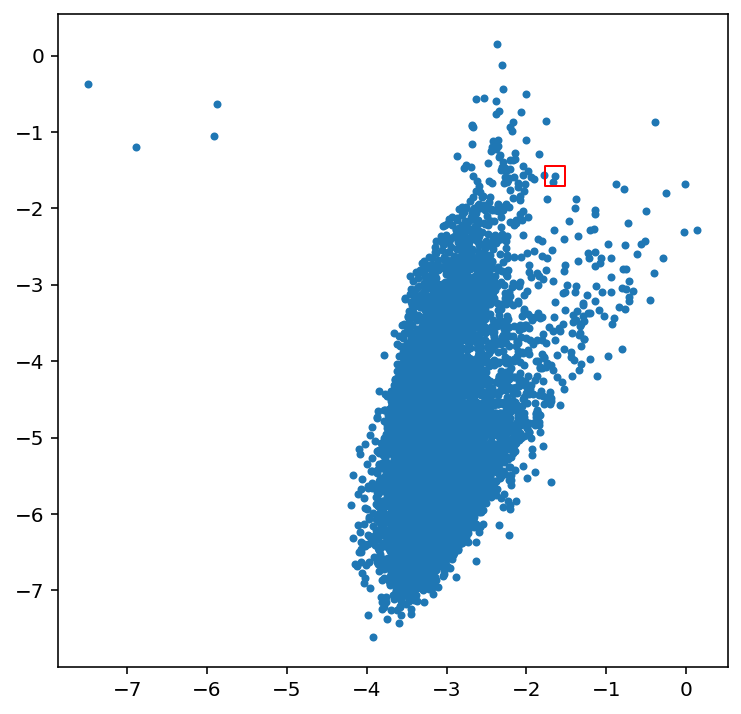

In [28]:
plt.figure(figsize=(6,6))
plt.plot(state_dict_post['gamma_widths'], state_dict_post['amplitudes'], '.');


plt.scatter(state_dict_post['gamma_widths'][ii], state_dict_post['amplitudes'][ii], 
            ec='r', fc = 'none', marker='s', s=100, zorder=10);

In [35]:
import seaborn as sns

In [36]:
sns.set_context('talk')

In [40]:
! mkdir ../figures

In [42]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

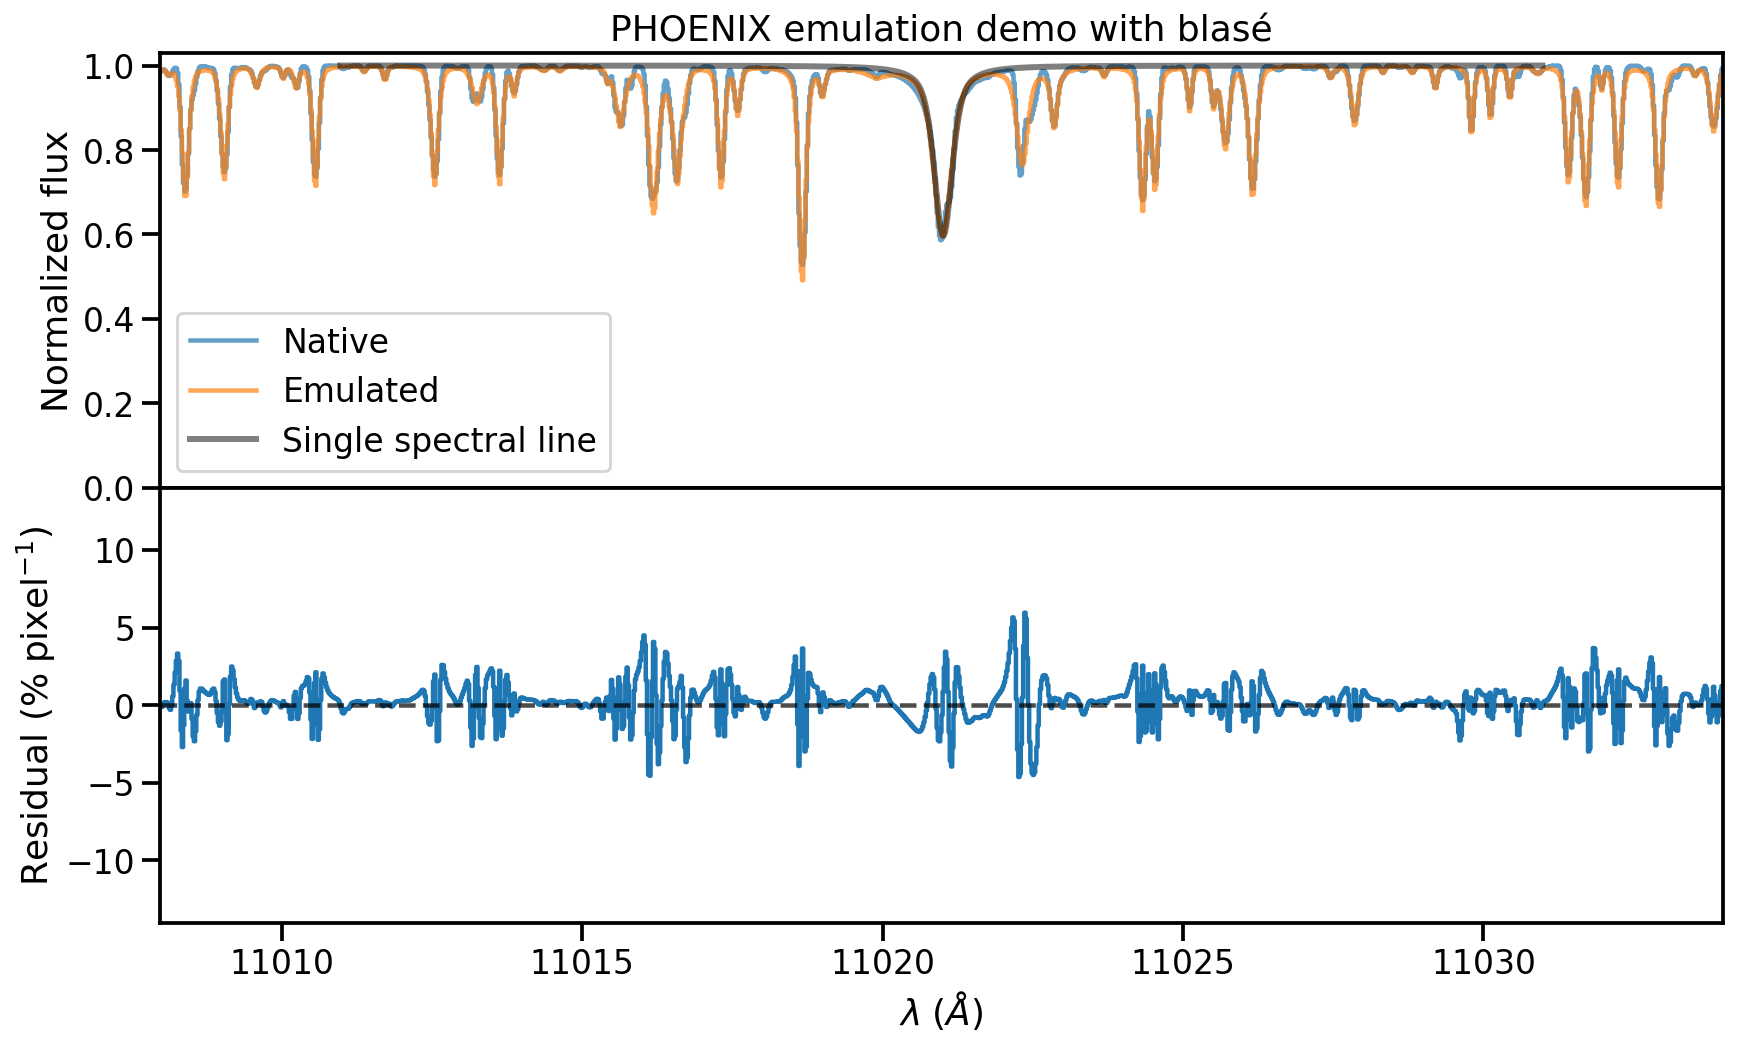

In [74]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True, squeeze=True)
axes[0].step(wl, flux, alpha=0.7, label = 'Native')
axes[0].step(wl, spec_out, alpha=0.7, label = 'Emulated')

axes[0].plot(emulator.wl_2D[ii, :], 1-flux_2D[ii, :], alpha=0.5, lw=3,color='k' ,label='Single spectral line')
axes[0].set_xlim(emulator.wl_2D[ii, :].min()-3, emulator.wl_2D[ii, :].max()+3)
axes[0].legend();

axes[0].set_ylim(0, 1.03)
axes[0].set_ylabel('Normalized flux');
axes[0].set_title('PHOENIX emulation demo with blasé')

axes[1].step(wl, (flux-spec_out)*100, alpha=1, label = 'Residual')
axes[1].axhline(0.0, linestyle='dashed', color='k', alpha=0.7)

axes[1].set_xlim(emulator.wl_2D[ii, :].min()-3, emulator.wl_2D[ii, :].max()+3)

axes[1].set_xlabel('$\lambda \; (\AA)$')
axes[1].set_ylabel('Residual $(\% \; \mathrm{pixel}^{-1})$');
#axes[1].set_ylim(-5.9, 5.9)
axes[1].set_ylim(-14, 14)

fig.subplots_adjust(hspace=0)
plt.savefig('../figures/PHOENIX_blase_residual.png', bbox_inches='tight', dpi=300, transparent=False)

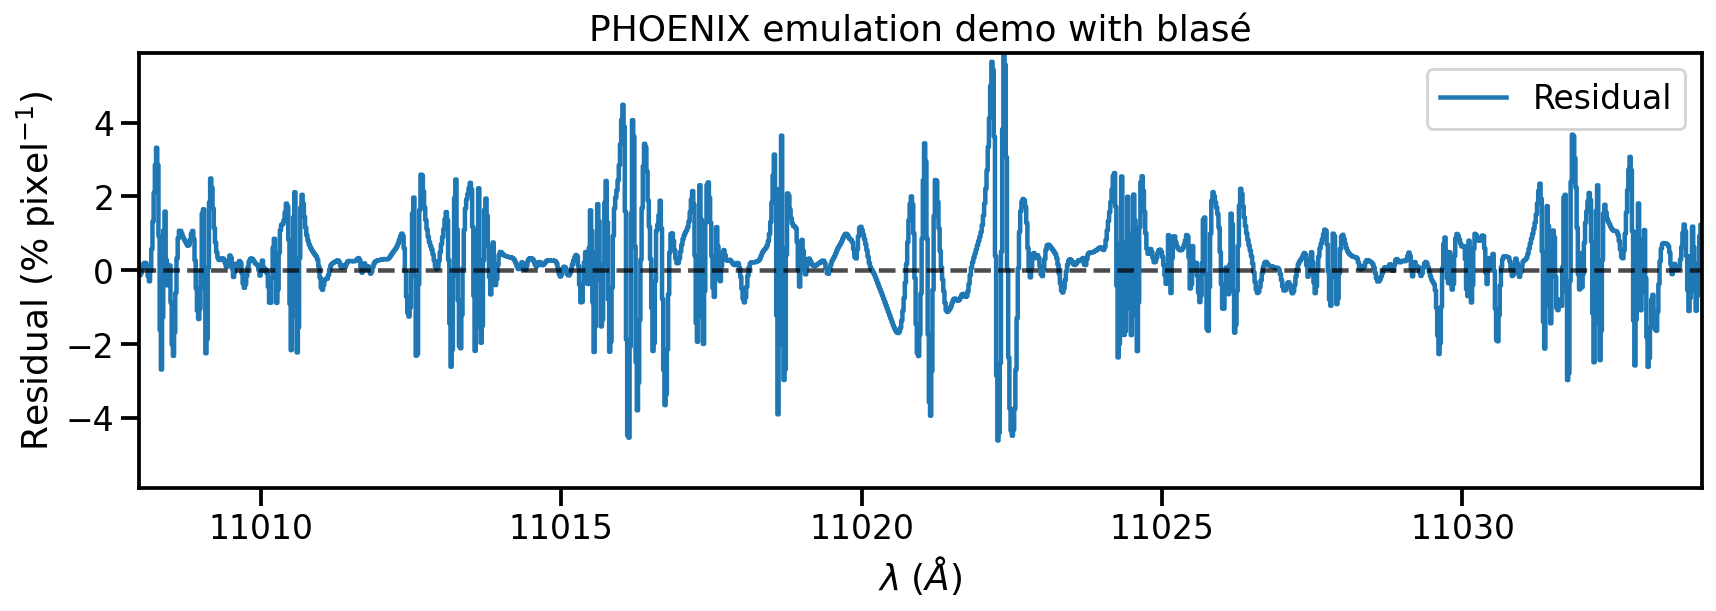

In [59]:
plt.figure(figsize=(14, 4))
plt.step(wl, (flux-spec_out)*100, alpha=1, label = 'Residual')
plt.axhline(0.0, linestyle='dashed', color='k', alpha=0.7)

plt.xlim(emulator.wl_2D[ii, :].min()-3, emulator.wl_2D[ii, :].max()+3)
plt.legend();

plt.xlabel('$\lambda \; (\AA)$')
plt.ylabel('Residual $(\% \; \mathrm{pixel}^{-1})$');
plt.title('PHOENIX emulation demo with blasé')
plt.ylim(-5.9, 5.9)
plt.savefig('../figures/PHOENIX_blase_residual.png', bbox_inches='tight', dpi=300, transparent=False)